In [1]:
import numpy as np
import torch
import torch.nn as nn
import seaborn as sns
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, mean_squared_error

In [2]:
def gaussian(alpha):
    phi = torch.exp(-1*alpha.pow(2))
    return phi

In [3]:
def linear(alpha):
    phi = alpha
    return phi

In [4]:
import torch
import torch.nn as nn

In [5]:
class RBF(nn.Module):
    def __init__(self, in_features, num_centers, basis_func):
        super(RBF, self).__init__()
        self.in_features = in_features
        self.num_centers = num_centers
        self.centers = nn.Parameter(torch.Tensor(num_centers, in_features))
        self.log_sigmas = nn.Parameter(torch.Tensor(num_centers))
        self.basis_func = basis_func
        self.reset_parameters()
        
    def reset_parameters(self):
        nn.init.normal_(self.centers, 0, 1)
        nn.init.constant_(self.log_sigmas, 0)

    def _euclidean_distance(self, a, b):
        return (a - b).pow(2).sum(-1).pow(0.5)

    def forward(self, inputs):
        size = (inputs.size(0), self.num_centers, self.in_features)
        x = inputs.unsqueeze(1).expand(size)
        c = self.centers.unsqueeze(0).expand(size)
        distances = self._euclidean_distance(x, c) / torch.exp(self.log_sigmas).unsqueeze(0)
        return self.basis_func(distances)

## Classification

In [6]:
x = np.arange(0, 1.5+0.004, 0.004)

In [7]:
first_x1 = np.sqrt(2*0.3*x)
first_x2 = -np.sqrt(2*0.3*x)
y1 = np.concatenate((first_x1, first_x2))
x1 = np.concatenate((x,x))

In [8]:
second_x1 = np.sqrt(2*0.5*x)
second_x2 = -np.sqrt(2*0.5*x)
y2 = np.concatenate((second_x1, second_x2))
x2 = np.concatenate((x,x)) - 0.4

In [9]:
third_x1 = np.sqrt(2*x)
third_x2 = -np.sqrt(2*x)
y3 = np.concatenate((third_x1, third_x2))
x3 = np.concatenate((x,x)) - 0.8

<AxesSubplot:>

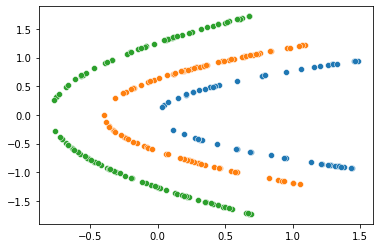

In [10]:
a = np.array(list(zip(x1, y1)))
ind = np.arange(0, len(a))
rind = np.random.choice(ind, 60)
x1_ = a[rind][:,0]
y1_ = a[rind][:,1]
sns.scatterplot(x=x1_, y=y1_)


a = np.array(list(zip(x2, y2)))
ind = np.arange(0, len(a))
rind = np.random.choice(ind, 100)
x2_ = a[rind][:,0]
y2_ = a[rind][:,1]
sns.scatterplot(x=x2_, y=y2_)


a = np.array(list(zip(x3, y3)))
ind = np.arange(0, len(a))
rind = np.random.choice(ind, 120)
x3_ = a[rind][:,0]
y3_ = a[rind][:,1]
sns.scatterplot(x=x3_, y=y3_)

In [11]:
q1 = np.array(list(zip(x1_, y1_)))
q2 = np.array(list(zip(x2_, y2_)))
q3 = np.array(list(zip(x3_, y3_)))

In [12]:
X = np.concatenate((q1, q2, q3))
Y = np.array([0]*60 + [1]*100 + [2]*120).reshape(-1,1)

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=42, test_size=0.2)

In [14]:
batch_size = 12
train_in_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train.astype(np.float32)), 
                                                  torch.tensor(y_train.ravel().astype(np.int64)))

valid_in_dataset = torch.utils.data.TensorDataset(torch.tensor(X_val.astype(np.float32)), 
                                                  torch.tensor(y_val.ravel().astype(np.int64)))

test_in_dataset = torch.utils.data.TensorDataset(torch.tensor(X_test.astype(np.float32)), 
                                                  torch.tensor(y_test.ravel().astype(np.int64)))

In [15]:
train_loader = torch.utils.data.DataLoader(train_in_dataset,
                                          batch_size=batch_size, shuffle=False)
val_loader = torch.utils.data.DataLoader(valid_in_dataset,
                                          batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_in_dataset,
                                          batch_size=batch_size, shuffle=False)

In [16]:
class Net(nn.Module):
    
    def __init__(self, in_features, out_features, num_centers, basis_func):
        super(Net, self).__init__()
        self.rbf = RBF(in_features, num_centers, gaussian)
        self.fc2 = nn.Linear(num_centers, out_features)
        
    def forward(self, x):
        x = self.rbf(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [17]:
net = Net(in_features=2, out_features=3, num_centers=40, basis_func=gaussian)
print(net)

Net(
  (rbf): RBF()
  (fc2): Linear(in_features=40, out_features=3, bias=True)
)


In [18]:
learning_rate = 0.05
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [19]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu", log_step=5):
    for epoch in range(1, epochs+1):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
#             print(inputs)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)
        
        model.eval()
        num_correct = 0 
        num_examples = 0
        preds = np.array([])
        actual = np.array([])
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output, targets) 
            valid_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(output, dim=1), dim=1)[1], targets)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader.dataset)

        if epoch % log_step == 0:
            print('Epoch: {}, Training Loss: {:.4f}, Validation Loss: {:.4f}, accuracy = {:.3f}'.format(
                    epoch, training_loss, valid_loss, num_correct / num_examples))

In [20]:
train(net, optimizer, criterion, train_loader, val_loader, epochs=5, log_step=1)

Epoch: 1, Training Loss: 0.9993, Validation Loss: 0.8944, accuracy = 0.600
Epoch: 2, Training Loss: 0.6868, Validation Loss: 0.6650, accuracy = 0.822
Epoch: 3, Training Loss: 0.4673, Validation Loss: 0.5199, accuracy = 0.822
Epoch: 4, Training Loss: 0.3747, Validation Loss: 0.4307, accuracy = 0.889
Epoch: 5, Training Loss: 0.3082, Validation Loss: 0.3678, accuracy = 0.933


In [21]:
centers = net.rbf.centers.detach().numpy()

In [22]:
from matplotlib.colors import ListedColormap

def plot_mesh_with_centers(X, y, model, centers):
    plt.figure(figsize=(15,9))
    colors = ['violet', 'lightgreen', 'crimson']
    cmap = ListedColormap(sns.color_palette(colors))
    
    x1_min, x1_max = X[:, 0].min()-2, X[:, 0].max()+2
    x2_min, x2_max = X[:, 1].min()-2, X[:, 1].max()+2
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, 0.005),
                           np.arange(x1_min, x1_max, 0.005))
    
    in_model = torch.tensor(np.array([xx1.ravel(), xx2.ravel()]).T).float()
    Z = model(in_model)
    output = torch.max(F.softmax(Z, dim=1), dim=1)[1]
    plt.contourf(xx1, xx2, output.reshape(xx2.shape), cmap=cmap)
    
    plt.scatter(X[y==0,0],X[y==0,1], s=80, cmap=cmap, c=colors[0], edgecolors='black')
    plt.scatter(X[y==1,0],X[y==1,1], s=80, cmap=cmap, c=colors[1], edgecolors='black')
    plt.scatter(X[y==2,0],X[y==2,1], s=80, cmap=cmap, c=colors[2], edgecolors='black')
    plt.scatter(centers[:, 0], centers[:, 1], c='blue', s=80, label='Centers')
    plt.legend()
    plt.show()

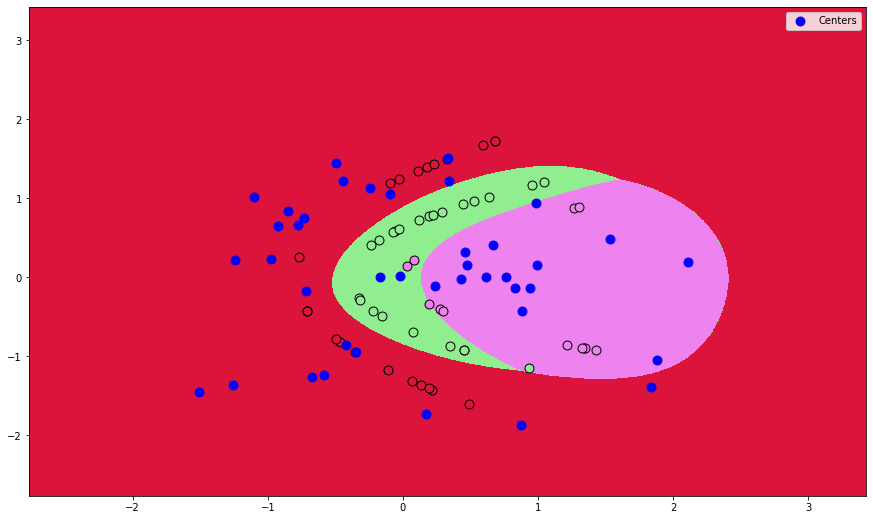

In [23]:
plot_mesh_with_centers(X_test, y_test.ravel(), net, centers)

In [24]:
centers.shape

(40, 2)

## Regression

### Не забываем, что для нейросетей мы нормируем входные данные!

In [25]:
from sklearn.preprocessing import StandardScaler

In [26]:
def fx(t):
    return np.sin(t*t-5*t+6)

<AxesSubplot:>

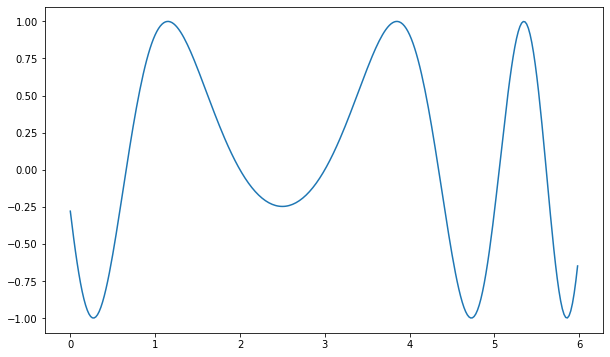

In [27]:
t = np.arange(0, 6, 0.02)
FX = fx(t)
plt.figure(figsize=(10,6))
sns.lineplot(x=t, y=FX)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(t, FX, test_size=0.3, random_state=42)

In [29]:
X_train = X_train.reshape(-1,1)
X_test = X_test.reshape(-1,1)
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [30]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [31]:
X_train.shape

(210, 1)

In [32]:
batch_size = 32
train_in_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train.astype(np.float32)), 
                                                  torch.tensor(y_train.astype(np.float32)))

valid_in_dataset = torch.utils.data.TensorDataset(torch.tensor(X_val.astype(np.float32)), 
                                                  torch.tensor(y_val.astype(np.float32)))

test_in_dataset = torch.utils.data.TensorDataset(torch.tensor(X_test.astype(np.float32)), 
                                                  torch.tensor(y_test.astype(np.float32)))

In [33]:
train_loader = torch.utils.data.DataLoader(train_in_dataset,
                                          batch_size=batch_size, shuffle=False)
val_loader = torch.utils.data.DataLoader(valid_in_dataset,
                                          batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_in_dataset,
                                          batch_size=batch_size, shuffle=False)

In [34]:
class Net(nn.Module):
    
    def __init__(self, in_features, out_features, num_centers, basis_func):
        super(Net, self).__init__()
        self.rbf = RBF(in_features, num_centers, gaussian)
        self.fc2 = nn.Linear(num_centers, 20)
        self.fc3 = nn.Linear(20, out_features)
        
    def forward(self, x):
        x = self.rbf(x)
        x = self.fc2(x)
        x = torch.tanh(x)
        x = self.fc3(x)
        x = torch.tanh(x)
        return x

Вроде как количество центроидов должно совпадать с размером обучающей выборки

In [35]:
net = Net(in_features=1, out_features=1, num_centers=40, basis_func=gaussian)
print(net)

Net(
  (rbf): RBF()
  (fc2): Linear(in_features=40, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=1, bias=True)
)


In [36]:
optimizer = optim.Adam(net.parameters(), lr=0.01)
criterion = nn.MSELoss()

In [37]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu", log_step=5):
    for epoch in range(1, epochs+1):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
#             print(inputs)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)
        
        model.eval()
        num_correct = 0 
        num_examples = 0
        preds = np.array([])
        actual = np.array([])
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output, targets) 
            valid_loss += loss.data.item() * inputs.size(0)
            preds = np.append(preds, output.ravel().data.detach().numpy())
            actual = np.append(actual, targets.ravel().data.detach().numpy())
        valid_loss /= len(val_loader.dataset)

        if epoch % log_step == 0:
            print('Epoch: {}, Training Loss: {:.4f}, Validation Loss: {:.4f}, mse = {:.7f}'.format(
                    epoch, training_loss, valid_loss, mean_squared_error(actual, preds)))

In [38]:
train(net, optimizer, criterion, train_loader, test_loader, epochs=50, log_step=5)

Epoch: 5, Training Loss: 0.3222, Validation Loss: 0.3848, mse = 0.3848030
Epoch: 10, Training Loss: 0.2097, Validation Loss: 0.2228, mse = 0.2227895
Epoch: 15, Training Loss: 0.1706, Validation Loss: 0.1644, mse = 0.1643683
Epoch: 20, Training Loss: 0.1452, Validation Loss: 0.1297, mse = 0.1296990
Epoch: 25, Training Loss: 0.1014, Validation Loss: 0.0735, mse = 0.0734961
Epoch: 30, Training Loss: 0.0343, Validation Loss: 0.0180, mse = 0.0179912
Epoch: 35, Training Loss: 0.0124, Validation Loss: 0.0065, mse = 0.0064514
Epoch: 40, Training Loss: 0.0101, Validation Loss: 0.0060, mse = 0.0060352
Epoch: 45, Training Loss: 0.0092, Validation Loss: 0.0054, mse = 0.0054435
Epoch: 50, Training Loss: 0.0088, Validation Loss: 0.0053, mse = 0.0052588


In [39]:
X_scaled = scaler.transform(t.reshape(-1,1))

In [40]:
res = []
for i in X_scaled:
    output = net(torch.tensor(i).float())
    res.append(output.data.detach().numpy()[0][0])

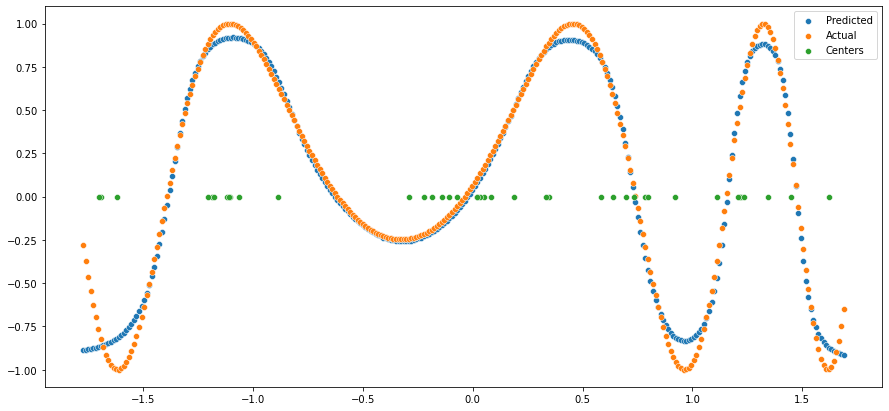

In [41]:
centers = net.rbf.centers.detach().numpy()
plt.figure(figsize=(15,7))
sns.scatterplot(x=X_scaled.ravel(), y=res, label='Predicted')
sns.scatterplot(x=X_scaled.ravel(), y=FX.ravel(), label='Actual')
sns.scatterplot(x=centers.ravel(), y=np.zeros(40), label='Centers')
plt.legend()

In [42]:
preds = []
for i in X_test:
    output = net(torch.tensor(i).float())
    preds.append(output.data.detach().numpy()[0][0])

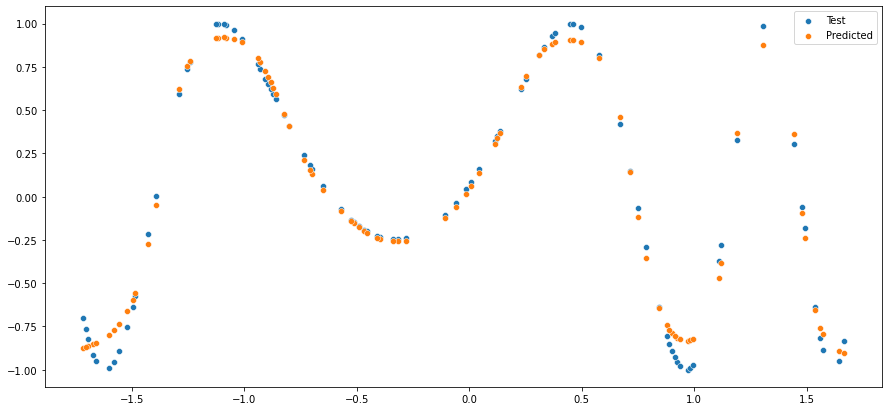

In [43]:
plt.figure(figsize=(15,7))
sns.scatterplot(x=X_test.ravel(), y=y_test.ravel(), label='Test')
sns.scatterplot(x=X_test.ravel(), y=preds, label='Predicted')
plt.legend()